# Partial wave analysis notebook
In the notebook I perform the mass-independent partial wave analysis in a single $m_{3\pi}$ bin.
 1. Prepare data: $M_{3\pi} \in [2.3, 2.31]\,$GeV
 2. Perpare Model: 88 waves, coherence $\text{FLAT}\otimes(\epsilon=+)\otimes(\epsilon=-)\otimes(\epsilon=-)$
 3. Perform fit: gradient based minimization in 186 dims

In [1]:
using JLD
using Plots

In [2]:
push!(LOAD_PATH,joinpath(pwd(),"src"))

3-element Array{Any,1}:
 "/home/mikhasenko/Tools/julia/usr/local/share/julia/site/v0.6"
 "/home/mikhasenko/Tools/julia/usr/share/julia/site/v0.6"      
 "/home/mikhasenko/Documents/pwa_from_scratch/src"             

In [3]:
using DalitzPlotAnalysis
using amplitudes_compass

## First step: data preparation

In [84]:
function precalculate_compass_basis(fin,fout)
    mm = readdlm(fin)#[1:1000,:];
    m2 = [COMPASS_wave(i,mm[e,:]...) for e=1:size(mm,1), i=1:88];
    save(fout,"real",real(m2),"imag",imag(m2))
end
function read_precalc_basis(fname)
    ld = load(fname)
    ld["real"]+1im*ld["imag"]
end

read_precalc_basis (generic function with 1 method)

### Precalculate basis functions on Data events and MC events
The basis functions are some complex functions of kinematical variables $\tau = s,(\sigma_1,\Omega_1,\Omega_{23})$.

In [73]:
let fl = open(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"))
    println("    s    sigma1   cosT1    phi1    cosT23    phi23")
    println("----------------------------------------------------")
    for i in 1:5
        println(readline(fl))
    end
end

    s    sigma1   cosT1    phi1    cosT23    phi23
----------------------------------------------------
5.29372 2.63656 0.449601 -2.23706 0.285533 3.03056
5.30077 2.57685 -0.450209 -2.56658 0.99015 1.25204
5.32275 3.02265 -0.0624672 1.22592 -0.280739 1.12741
5.29445 2.8794 0.256868 0.147668 0.622066 0.308702
5.3206 1.66012 0.0670138 1.97324 -0.542003 -1.28583


We calculate and save to the file the following matrix $N_\text{ev}\times 88$
$$
[\,\Psi_i(\tau_e)\,],\quad \forall i = 1,\dots,88,\quad e = 1,\dots,N_\text{ev}
$$

In [5]:
# @time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"), "mc.jld")
# 355.232697 seconds (3.05 G allocations: 93.994 GiB, 3.26% gc time)

In [6]:
# @time precalculate_compass_basis(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.rd.txt"), "rd.jld")
# 64.127467 seconds (581.89 M allocations: 17.920 GiB, 3.64% gc time)

In [7]:
const PsiMC = read_precalc_basis("mc.jld"); # [1:1000,:];

In [8]:
@time sum_mat = [sum(PsiMC[e,i]'*PsiMC[e,j] for e in 1:size(PsiMC,1)) for i=1:88, j=1:88]/size(PsiMC,1);
# 10.593515 seconds (101.00 k allocations: 4.752 MiB)

  7.607756 seconds (117.71 k allocations: 5.659 MiB)


In [9]:
sum_mat_n = [sum_mat[i,j]/sqrt(sum_mat[i,i]*sum_mat[j,j]) for i=1:88, j=1:88];

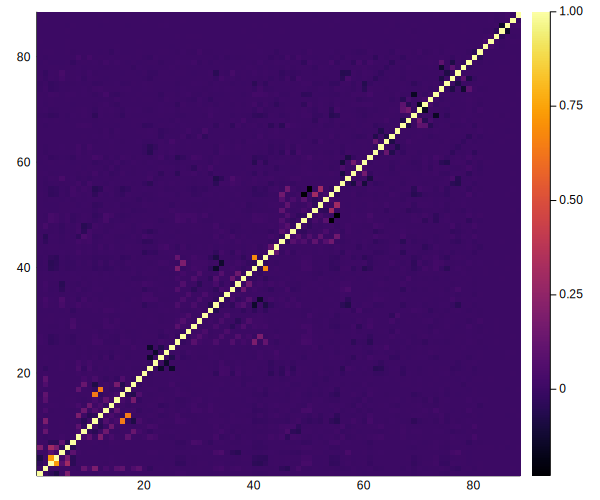

In [10]:
heatmap(real(sum_mat_n), size=(600,500))

## Second step: Model preparation
Files contains the list of waves with $J$ $P$ $L$ $S$ classification

In [11]:
waves = readdlm(pwd()*"/src/wavelist_formated.txt");

In [12]:
const noϵ = [i==1 for i=1:size(waves[:,6],1)]
const posϵ = [ϵ=="+" for ϵ in waves[:,6]]
const negϵ = [ϵ=="-" for ϵ in waves[:,6]];

Coherence matrix has block-diagonal form
$$
\begin{pmatrix}
\text{FLAT} && &\\
&\epsilon = + & &\\
& &\epsilon = - &\\
& & &\epsilon = -\\
\end{pmatrix}
$$

In [ ]:
const ModelBlocks = [noϵ,posϵ,negϵ,negϵ]

### A bit of Lineal Algebra:
Naively, one would write the intensity as
$$
I = \left|\,\Psi_i c_i\,\right|^2
$$
We add more information to the model: some function are not allowed to interfer.
Particularly,
 * there are different reflectivities which do not interfere due to the proton helicity.
 * There is the FLAT wave to pick up phase space like background.
 * The corerent blocks might have different rank which essentially makes more non-interfering blocks.
 
Therefore, we introduce the index $\beta$ which numbers blocks
$$
I = \sum_{\beta}\left|\,\Psi_i^{\beta} c_i\,\right|^2
$$

Finally, the parameters suppose to be complex. All except the first one in the block to fix the overall phase for every block.


Still, the intensity can be written as a bilinear combination of the __real__ parameters $c_i$:
$$
I = c_i I_{ij} \Psi_j^* \left( \sum_\beta t_\beta t_\beta^T\right)_{jb} c_a I_{ab} \Psi_b,
$$
where the matrix $I_{ij}$ maps the basis functions to the real parameters, $t_\beta$ are vectors in the form 
$$
(0,\dots,0,\underbrace{1,1,\dots,1}_{\textrm{coherence block}},0,\dots,0)
$$
which make required coherence.


Below I code those function in the callback form based on the `ModelBlocks`-input:
 * `extend_psi(Psi)` does fast multiplication $I_{ij}\,\Psi_j$
 * `COHsq(X)` does fast bilinear contraction with the coherent matrix. Returns $X \,( \sum_\beta t_\beta t_\beta^T)\, X$
 * `COHts(X)` does fast oneside contraction with the coherent matrix. Returns $( \sum_\beta t_\beta t_\beta^T)\, X$

#### Map of parameters $I_{ij}$: real values $\to$ a certain basis function

In [13]:
function get_parameter_map(block_masks)
    temp = []; numb = []
    for (i,bl) in enumerate(ModelBlocks)
        # push false for the first parameter, true for others 
        push!(temp,false,[true for i=1:(sum(bl)-1)]...);
        push!(numb,collect(1:88)[bl]...)
    end
    Tmap = fill(0,2,sum(temp+1))
    count=1
    for (i,b) in enumerate(temp)
        Tmap[1,count] = numb[i]
        count+=1
        if b
            Tmap[2,count] = numb[i];
            count+=1
        end
    end
    Tmap
end
get_parameter_map([noϵ,posϵ,negϵ,negϵ])

2×186 Array{Int64,2}:
 1  2  3  0  4  0  5  0  6  0  7  0  8  …   0  85   0  86   0  87   0  88   0
 0  0  0  3  0  4  0  5  0  6  0  7  0     84   0  85   0  86   0  87   0  88

#### Coherent blocks in the parameter space

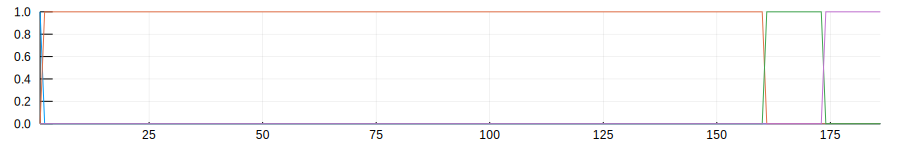

In [14]:
function make_pblock_masks(block_masks)
    just_true = [fill(true,2sum(bl)-1) for bl in block_masks]
    tmp = fill(false,sum(sum(jt) for jt in just_true))
    # to be filed
    pbls = copy(block_masks) 
    counter = 1
    for (i,jt) in enumerate(just_true)
        pbls[i] = copy(tmp)
        jtlen = length(jt)
        pbls[i][counter:(counter+jtlen-1)] .= true
        counter += jtlen
    end
    pbls
end
plot(make_pblock_masks(ModelBlocks), size=(900,150), lab="")

Three functions returning callbacks adjusted to the model

In [86]:
function make_function_to_extend_psi(block_masks)
    Tmap = get_parameter_map(block_masks)
    Np = size(Tmap,2)
    extend(Ψ) = [((Tmap[2,i]==0) ? Ψ[Tmap[1,i]] : 1im*Ψ[Tmap[2,i]]) for i in 1:Np]
    extend
end

function make_COHsq(block_masks)
    pblocks = make_pblock_masks(block_masks)
    function COHsq(X::Vector{Complex{Float64}})
        sum(abs2(sum(X[bl])) for bl in pblocks)
    end
    return COHsq
end

function make_COHts(block_masks)
    pblocks = make_pblock_masks(block_masks)
    function COHts(X::Vector{Complex{Float64}})
        sum(sum(X[bl])*bl for bl in pblocks)
    end
    return COHts
end

make_COHts (generic function with 1 method)

In [91]:
function contract_to_intensity(ΨΨstar, block_masks)
    Tmap = get_parameter_map(block_masks)
    pblocks = make_pblock_masks(block_masks)
    COH = sum(bl*bl' for bl in pblocks)
    Np = size(Tmap,2)
    get(v,w) = (v==0 || w==0) ? 0.0im : ΨΨstar[v,w]
    [COH[i,j]*( # meaning is ([1]-i[2]) * ([1]+i[2])
            get(Tmap[1,i],Tmap[1,j]) +
            get(Tmap[2,i],Tmap[2,j]) -
        1im*get(Tmap[2,i],Tmap[1,j]) +
        1im*get(Tmap[1,i],Tmap[2,j])
            ) for j in 1:Np, i in 1:Np]
end

contract_to_intensity (generic function with 1 method)

In [30]:
const BM = real.(contract_to_intensity(sum_mat,ModelBlocks));

### Real data

In [20]:
const BF = read_precalc_basis("rd.jld")#[1:10000,:]
const Nd = size(BF,1);

Likelihood functions

In [21]:
COHts = make_COHts(ModelBlocks)
COHsq = make_COHsq(ModelBlocks)
Extnd = make_function_to_extend_psi(ModelBlocks)

function LLH(pars)
    res = sum(log(COHsq(Extnd(BF[e,:]).*pars)) for e in 1:Nd)
    - res + real(sum(pars[i]*BM[i,j]*pars[j] for i=1:length(pars), j=1:length(pars))) * Nd
end

function getDv(psi::Vector{Complex{Float64}}, pars::Vector{Float64})
    ExtΨ = Extnd(psi)
    cv = (conj.(ExtΨ)).*COHts(ExtΨ.*pars)
    return real(cv)
end

function LLH_and_GRAD!(pars, grad)
    val = 0.0; grad .= 0.0
    for e in 1:Nd
        v = getDv(BF[e,:],pars)
        vale = pars'*v
        grad .-= v / vale
        val -= log(vale);
    end
    grad .*= 2.0

    BB = BM*pars;
    val += pars'*BB * Nd;
    grad .+= BB* (2Nd);
    return val;
end

LLH_and_GRAD! (generic function with 1 method)

In [31]:
test_t = rand(186);

In [103]:
@time LLH(test_t)

124.244366 seconds (4.52 M allocations: 1002.028 MiB, 33.17% gc time)


2.3846257317021385e7

In [34]:
using NLopt

In [35]:
function minimize(; verbose::Int=0, starting_pars::Vector{Float64} = rand(size(TT,2)))
    function to_minimize(x::Vector, grad::Vector)
        if length(grad) > 0
            v = LLH_and_GRAD!(x,grad)
        else
            v = LLH(x)
        end
        verbose==1 && @show v
        verbose==2 && @show v,x
        verbose==3 && @show v,grad
        return v;
    end
    opt = Opt(:LD_LBFGS, length(starting_pars)) # try LD_LBFGS || LD_MMA
    xtol_rel!(opt,1e-4)
    maxeval!(opt,500000)

    min_objective!(opt, to_minimize)

    (minf,pars,ret) = optimize(opt, starting_pars)#rand(size(TT,2)))
    println("got $minf at $pars = [m, Γ] after some iterations (returned $ret)")
    pars
end

minimize (generic function with 1 method)

In [115]:
# @time minpars = minimize(verbose=1, startpars=test_t)

In [93]:
# writedlm("min1e6.txt", minpars)
minpars0 = vcat(readdlm("minAll2.txt")...);

In [94]:
@time minpars = minimize(verbose=1, starting_pars=minpars0)

v = 5992.018459507526
v = 6032.839740389056
v = 5992.022470390002
v = 5992.018459894462
v = 5992.018459508457
v = 5992.018459507919
got 5992.018459507919 at [-0.434262, 0.0327209, 0.0183485, 0.100376, 0.00599833, -0.0224557, -0.027355, 0.00208934, 0.0887253, 0.0218734, -0.0119083, 0.163183, -0.000327964, 0.0172048, -0.017718, -0.000552675, 0.000363961, 0.0071654, 0.365228, -0.0738679, 0.0229541, -0.0150325, -0.211588, -0.139002, 0.0679681, -0.00333573, -0.0188566, 0.151521, 0.0283716, 0.0356322, -0.000875592, 0.00898132, -0.0799864, -0.0158952, 0.0632708, 0.419439, -0.00357216, 0.0208313, -0.0063997, -0.00775685, 0.00834663, -0.00617058, 0.100673, -0.0306546, -0.0766647, -0.000307987, 0.00161163, 0.0201474, -0.0328957, 0.167866, 0.0189451, -0.0214733, -0.00554988, 0.0235158, 0.0342988, -0.194217, 0.0645319, 0.0302708, 0.00520614, 0.0356234, 0.0497859, -0.0804135, 0.0245687, 0.0184578, 0.00260765, -0.0199491, 0.00361372, 0.00397946, -0.0287605, -0.0381593, -0.00707807, 0.0058865, 0.0662

186-element Array{Float64,1}:
 -0.434262   
  0.0327209  
  0.0183485  
  0.100376   
  0.00599833 
 -0.0224557  
 -0.027355   
  0.00208934 
  0.0887253  
  0.0218734  
 -0.0119083  
  0.163183   
 -0.000327964
  ⋮          
 -0.00611352 
  0.00663517 
  0.00328846 
  0.00487466 
 -0.000955025
  0.00356005 
  0.0747648  
  0.0169479  
  0.0529768  
  0.143479   
  0.00362679 
  0.0494073  

In [123]:
writedlm("minAll.txt", minpars)

## Compare disributions

In [37]:
function swap_kin_parameters(κ1::Vector{Float64})
    τ = change_basis(κ1[2:end]...,0.13957^2,0.13957^2,0.13957^2,κ1[1])
    κ3 = zero(κ1)
    κ3[1] = κ1[1]
    κ3[2] = τ[1]
    κ3[3] = τ[2]
    κ3[4] = τ[3]
    κ3[5] = -τ[4] # angle of the oposite particle
    κ3[6] = τ[5]+π # angle of the oposite particle
    (κ3[6] > π) && (κ3[6] -= 2π)
    κ3
end

swap_kin_parameters (generic function with 1 method)

In [38]:
const MC1 = readdlm(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.mc.txt"));

In [39]:
@time const MC3 = hcat([swap_kin_parameters(MC1[e,:]) for e in 1:size(MC1,1)]...)';

  3.689335 seconds (28.97 M allocations: 968.754 MiB, 16.65% gc time)


In [40]:
COMPASS_wave(5,MC1[1,:]...)-COMPASS_wave(5,MC3[1,:]...)

-3.5363814199218524e-7 + 1.0042610493199433e-8im

In [95]:
@time weights = let mpars = minpars
    [COHsq(Extnd(PsiMC[i,:]).*mpars) for i in 1:size(PsiMC,1)];
    end;

285.466856 seconds (21.11 M allocations: 5.092 GiB, 0.49% gc time)


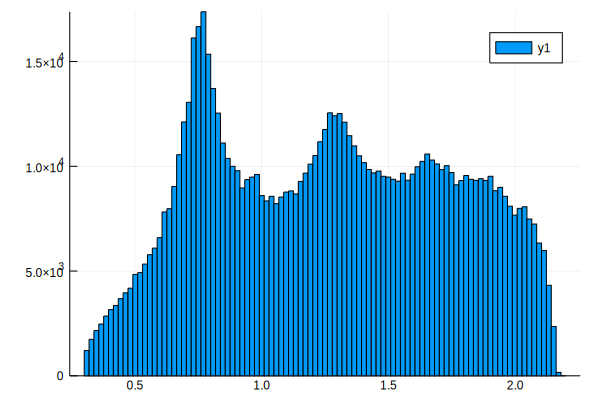

In [102]:
histogram(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights), bins=(linspace(0.3,2.2,100)))

In [43]:
const DT1 = readdlm(joinpath(ENV["HOME"],"cernbox","tmp","pwa_from_scratch_data","2300.rd.txt"));
# const DT1 = readdlm(ENV["HOME"]*"/cernbox/tmp/pwa_from_scratch_data/2300.rd.txt");

In [44]:
@time const DT3 = hcat([swap_kin_parameters(DT1[e,:]) for e in 1:size(DT1,1)]...)';

  0.645526 seconds (5.53 M allocations: 184.280 MiB, 9.74% gc time)


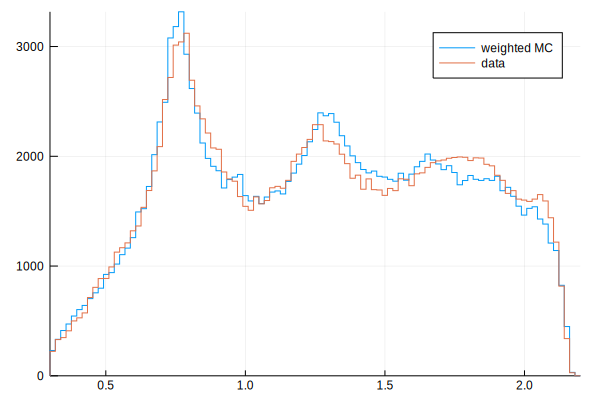

In [97]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

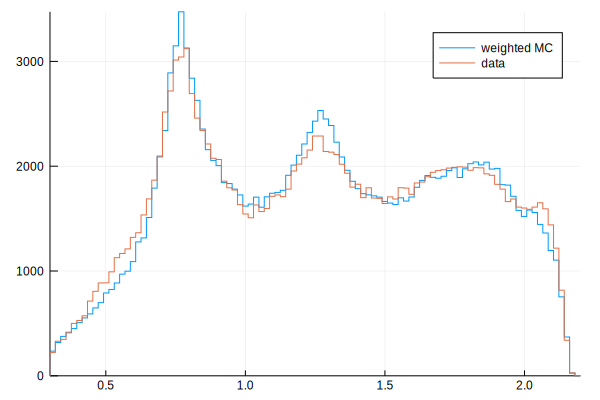

In [45]:
stephist(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC")
stephist!(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data") 

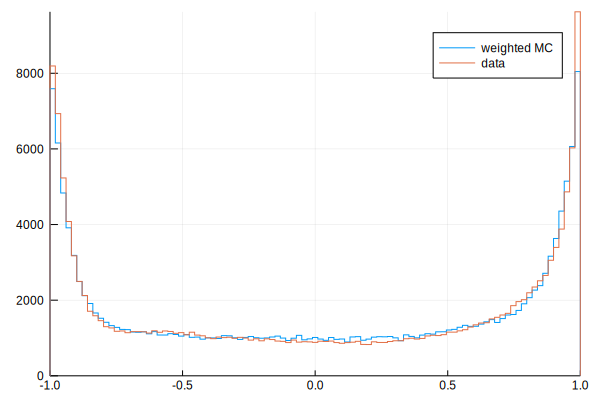

In [98]:
stephist(vcat(MC1[:,3],MC3[:,3]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,3],DT3[:,3]), bins=linspace(-1,1,100),lab="data") 

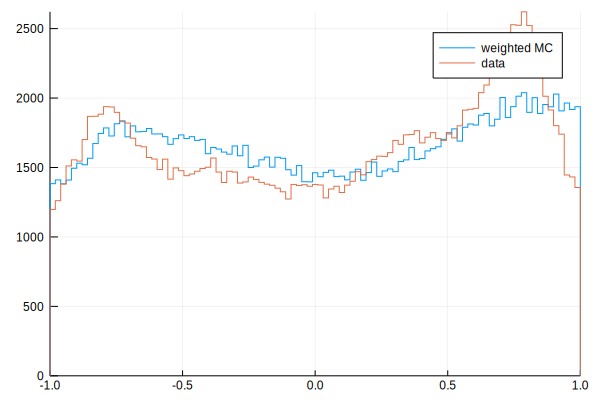

In [101]:
stephist(vcat(MC1[:,5],MC3[:,5]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-1,1,100),lab="weighted MC")
stephist!(vcat(DT1[:,5],DT3[:,5]), bins=linspace(-1,1,100),lab="data") 

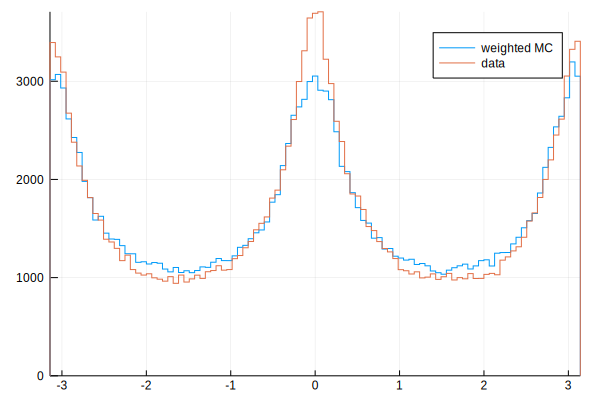

In [100]:
stephist(vcat(MC1[:,6],MC3[:,6]), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(-π,π,100),lab="weighted MC")
stephist!(vcat(DT1[:,6],DT3[:,6]), bins=linspace(-π,π,100),lab="data") 

### Plot individual components

In [48]:
isobars = [[w==p for w in waves[:,7]] for p in -2:3];

In [51]:
@time weightsI = let 
    [[COHsq(Extnd(PsiMC[i,:].*isobars[p]).*minpars) for i in 1:size(PsiMC,1)] for p in 1:size(isobars,1)];
end;
# 156.237099 seconds (178.42 M allocations: 16.042 GiB, 1.55% gc time)

 85.508011 seconds (193.88 M allocations: 36.753 GiB, 6.61% gc time)


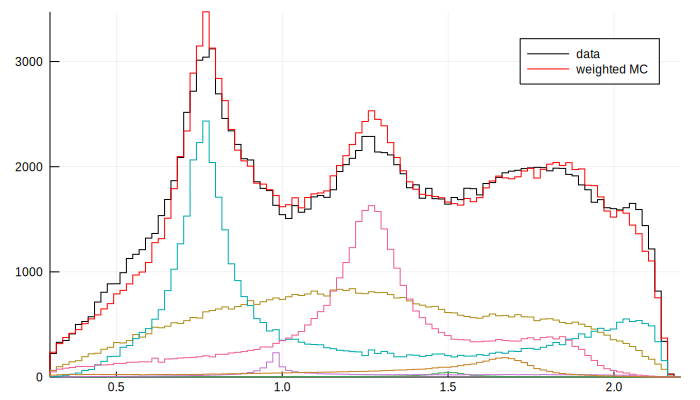

In [57]:
stephist(sqrt.(vcat(DT1[:,2],DT3[:,2])), bins=linspace(0.3,2.2,100),lab="data",lc=:black) 
stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weights,weights)/size(MC1,1)*size(DT1,1),
    bins=linspace(0.3,2.2,100),lab="weighted MC",lc=:red)
for p in 1:size(isobars,1)
    stephist!(sqrt.(vcat(MC1[:,2],MC3[:,2])), weights=vcat(weightsI[p],weightsI[p])/size(MC1,1)*size(DT1,1),
        bins=linspace(0.3,2.2,100),lab="")
end
plot!(size=(700,400))